In [2]:
import pandas as pd
import numpy as np
import joblib
import os

In [3]:
hdb_resale_data = pd.read_csv('data/processed/hdb_resale_data_final.csv', index_col=0)

In [4]:
hdb_resale_data.shape

(249857, 13)

In [5]:
hdb_resale_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,num_mrts_within_1km,min_dist_to_mrt_km
_id,,,,,,,,,,,,,
1,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,1,0.352915
2,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0,0,0.816023
3,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0,1,0.229604
4,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0,1,0.664472
5,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0,0,0.923402


<h2> Baseline Models

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [7]:
def create_preprocessor(numerical_cols, categorical_cols):
    numerical_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return preprocessor

In [8]:
model_scores = {}

In [9]:
numerical_columns = hdb_resale_data.select_dtypes(include=['int64', 'float64']).columns.drop(['resale_price'])
categorical_columns = hdb_resale_data.select_dtypes(include=['object', 'category']).columns.drop(['month', 'block', 'street_name'])

preprocessor = create_preprocessor(numerical_columns, categorical_columns)

X = hdb_resale_data.drop(['month', 'block', 'resale_price', 'street_name'], axis=1)

X_processed = preprocessor.fit_transform(X)
y = np.log(hdb_resale_data['resale_price'])

X_processed.shape

(249857, 76)

<h3> Basic Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate

In [11]:
linear_model = LinearRegression()

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "r2": "r2",
    "rmse": make_scorer(rmse)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(linear_model, X_processed, y, cv=kf, scoring=scoring)

model_scores['LinearRegression'] = {
    "r2": np.mean(cv_results["test_r2"]),
    "rmse": np.mean(cv_results["test_rmse"])
}   

print("Average R² score:", model_scores['LinearRegression']['r2'])
print("Average RMSE:", model_scores['LinearRegression']['rmse'])

linear_model.fit(X_processed, y)
joblib.dump(linear_model, "models/linear_regression_model.pkl")

Average R² score: 0.8828652871124097
Average RMSE: 0.11671962388660384


['models/linear_regression_model.pkl']

<h3> Random Forest Regression

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    rf_model, 
    param_grid=rf_params,
    cv=kf,
    scoring=scoring,
    refit='r2',
    n_jobs=-1, 
    verbose=2)

if os.path.exists("models/random_forest_model.pkl"):
    rf_grid = joblib.load("models/random_forest_model.pkl")
    print("Loaded Random Forest GridSearch from disk")
else : 
    rf_grid.fit(X_processed, y)

    model_scores['RandomForest'] = {
        "r2": rf_grid.cv_results_['mean_test_r2'][rf_grid.best_index_],
        "rmse": rf_grid.cv_results_['mean_test_rmse'][rf_grid.best_index_]
    }   

    joblib.dump(rf_grid, "models/random_forest_model.pkl")

print("Best parameters:", rf_grid.best_params_)
print("Average R² score:", model_scores['RandomForest']['r2'])
print("Average RMSE:", model_scores['RandomForest']['rmse'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Average R² score: 0.9688399403590437
Average RMSE: 0.06019911954385622


<h4> XGBoost Model

In [13]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)

xgb_params = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_grid = GridSearchCV(
    xgb_model, 
    param_grid=xgb_params, 
    cv=5, 
    scoring=scoring,
    refit='r2', 
    n_jobs=-1,
    verbose=2)

if os.path.exists("models/xgb_model.pkl"):
    xgb_grid = joblib.load("models/xgb_model.pkl")
    print("Loaded XGBoost GridSearch from disk")
else:
    xgb_grid.fit(X_processed, y)

    model_scores['XGBoost'] = {
        "r2": xgb_grid.cv_results_['mean_test_r2'][xgb_grid.best_index_],
        "rmse": xgb_grid.cv_results_['mean_test_rmse'][xgb_grid.best_index_]
    }   

    joblib.dump(xgb_grid, "models/xgb_model.pkl")

print("Best parameters:", xgb_grid.best_params_)
print("Average R² score:", model_scores['XGBoost']['r2'])
print("Average RMSE:", model_scores['XGBoost']['rmse'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Average R² score: 0.9357241475347229
Average RMSE: 0.07801774000077133


<h2> Addressing Multicollinearity

In [14]:
model_scores2 = {}

<h4> Ridge Regression Model

In [15]:
from sklearn.linear_model import Ridge

In [17]:
ridge_model = Ridge()

ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(
    estimator=ridge_model, 
    param_grid=ridge_params, 
    cv=kf, 
    scoring=scoring,
    refit='r2')

if os.path.exists("models/ridge_regression_model.pkl"):
    ridge_grid = joblib.load("models/ridge_regression_model.pkl")
    print("Loaded Ridge Regression GridSearch from disk")
else:
    ridge_grid.fit(X_processed, y)

    model_scores2['RidgeRegression'] = {
        "r2": ridge_grid.cv_results_['mean_test_r2'][ridge_grid.best_index_],
        "rmse":ridge_grid.cv_results_['mean_test_rmse'][ridge_grid.best_index_]
    }   

    joblib.dump(ridge_grid, "models/ridge_regression_model.pkl")

print("Best parameters:", ridge_grid.best_params_)
print("Average R² score:", model_scores2['RidgeRegression']['r2'])
print("Average RMSE:", model_scores2['RidgeRegression']['rmse'])



Best parameters: {'alpha': 1}
Average R² score: 0.8828653253416894
Average RMSE: 0.1167196097510926


<h2> Model Evaluation

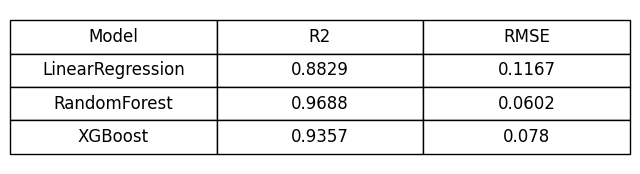

In [18]:
import matplotlib.pyplot as plt

model_evaluation = pd.DataFrame(model_scores).T
model_evaluation.reset_index(inplace=True)
model_evaluation.rename(columns={'index': 'Model'}, inplace=True)

model_evaluation.columns = ['Model', 'R2', 'RMSE']

model_evaluation['R2'] = model_evaluation['R2'].apply(lambda x: round(x, 4))
model_evaluation['RMSE'] = model_evaluation['RMSE'].apply(lambda x: round(x, 4))

fig, ax = plt.subplots(figsize=(4, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=model_evaluation.values, colLabels=model_evaluation.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2,2)
plt.show()

<h1>All model Evaluation

In [ ]:
models = {
    'LinearRegression': linreg_model,
    'RidgeRegression': grid_ridge,
    'RandomForest': grid_rf,
    'XGBoost': grid_xgb
}

for model_name, model in models.items():
    print(f'Evaluate: {model_name}')

    if model_name == 'RidgeRegression':
        X_train, X_test, y_train, y_test = train_test_split(X_processed_ridge, y, test_size=0.2, random_state=42)
    else :
        X_train, X_test, y_train, y_test = train_test_split(X_processed_linreg, y, test_size=0.2, random_state=42)

    y_pred = models[model_name].predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Best MSE: {mse}')
    print(f'Best RMSE: {np.sqrt(mse)}')
    print(f'Best R-squared: {r2}\n')


Evaluate: LinearRegression
Best MSE: 0.0283449602712867
Best RMSE: 0.16835961591571388
Best R-squared: 0.7580881194124137

Evaluate: RidgeRegression
Best MSE: 0.010827529217803496
Best RMSE: 0.10405541416862217
Best R-squared: 0.9075917577542267

Evaluate: RandomForest
Best MSE: 0.0007925026773515388
Best RMSE: 0.028151424073242528
Best R-squared: 0.993236335094002

Evaluate: XGBoost
Best MSE: 0.007564128205273953
Best RMSE: 0.08697199667291738
Best R-squared: 0.9354434629073354



<h2>POST COVID DATA ONLY

In [ ]:
hdb_resale_data['month'] = pd.to_datetime(hdb_resale_data['month'])
hdb_resale_from_2020 = hdb_resale_data[hdb_resale_data['month'] >= '2020-01-01']

hdb_resale_from_2020.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,num_mrts_within_1km,min_dist_to_mrt_km
_id,,,,,,,,,,,,,
64257,2020-01-01,ANG MO KIO,3 ROOM,208,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,55,265000.0,0,0.902255
64258,2020-01-01,ANG MO KIO,3 ROOM,307C,ANG MO KIO AVE 1,19 TO 21,70.0,Model A,2012,91,470000.0,1,0.674136
64259,2020-01-01,ANG MO KIO,3 ROOM,319,ANG MO KIO AVE 1,01 TO 03,73.0,New Generation,1977,56,230000.0,1,0.563682
64260,2020-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,55,280000.0,0,0.836529
64261,2020-01-01,ANG MO KIO,3 ROOM,556,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,59,220000.0,0,0.923578


In [ ]:
num_cols = hdb_resale_from_2020.select_dtypes(include=['int64', 'float64']).columns.drop(['resale_price'])
cat_cols = hdb_resale_from_2020.select_dtypes(include=['object', 'category']).columns.drop(['block', 'street_name'])

preprocessor = create_preprocessor(num_cols, cat_cols)

X = hdb_resale_from_2020.drop(['month', 'block'], axis=1)

X_processed = preprocessor_ridge.fit_transform(X)
y = np.log(hdb_resale_from_2020['resale_price'])

print(X_processed.shape)
print(y.shape)

(148448, 651)
(148448,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Linear_Regression': LinearRegression(),
    'Ridge_Regression': Ridge(),
    'Random_Forest': RandomForestRegressor(),
    'XGB':XGBRegressor()
}

param_grids = {
    'Linear_Regression' : {},
    'Ridge_Regression' : {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Random_Forest' : {
        'n_estimators': [100, 200],
        'max_depth': [10, 30],
        'min_samples_split': [2],
    },
    'XGB' : {
        'n_estimators': [100, 200],
        'learning_rate': [0.1],
        'max_depth': [3, 6],
    }
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

grids = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')

    grids[model_name] = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=cv, scoring='r2', n_jobs=-1, verbose=2
    )

    grids[model_name].fit(X_train, y_train)

    print(f'Best parameters for {model_name}: {grids[model_name].best_params_}')
    print(f'Best R2 for {model_name}: {grids[model_name].best_score_}\n')

    joblib.dump(grids[model_name], f'models/{model_name.lower()}_from2020_gridsearch.pkl')


Training and tuning Linear_Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters for Linear_Regression: {}
Best R2 for Linear_Regression: 0.9495891055166523

Training and tuning Ridge_Regression...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for Ridge_Regression: {'alpha': 0.1}
Best R2 for Ridge_Regression: 0.9495922842883253

Training and tuning Random_Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for Random_Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Best R2 for Random_Forest: 0.9595860166025952

Training and tuning XGB...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for XGB: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best R2 for XGB: 0.9457526706108057



In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

for model_name, grid in grids.items():
    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f"{model_name} -> Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}, Test RMSE: {rmse_test:.2f}")


Linear_Regression -> Train R2: 0.9504, Test R2: 0.9501, Test RMSE: 0.07
Random_Forest -> Train R2: 0.9926, Test R2: 0.9646, Test RMSE: 0.06
XGB -> Train R2: 0.9503, Test R2: 0.9471, Test RMSE: 0.08


Very solid baseline model

In [ ]:
hdb_resale_from_2020['storey_range'].unique()

array(['04 TO 06', '19 TO 21', '01 TO 03', '07 TO 09', '10 TO 12',
       '16 TO 18', '13 TO 15', '28 TO 30', '25 TO 27', '22 TO 24',
       '34 TO 36', '31 TO 33', '37 TO 39', '46 TO 48', '40 TO 42',
       '49 TO 51', '43 TO 45'], dtype=object)

In [ ]:
new_data = pd.DataFrame([
    { 'month': '2025-08-20', 'town': 'ANG MO KIO', 'flat_type': '3 ROOM', 'block': '124', 'street_name': 'ANG MO KIO AVE 6', 'storey_range': '7 TO 9', 'floor_area_sqm': 67.0, 'flat_model': 'New Generation', 'lease_commence_date': 1977, 'remaining_lease': 52, 'resale_price': 430000.0,  'num_mrts_within_1km': 1, 'min_dist_to_mrt_km': 0.9},
    { 'month': '2025-08-20', 'town': 'JURONG EAST', 'flat_type': '3 ROOM', 'block': '247', 'street_name': 'Jurong East St 24', 'storey_range': '13 TO 15', 'floor_area_sqm': 68.0, 'flat_model': 'New Generation', 'lease_commence_date': 1981, 'remaining_lease': 56, 'resale_price': 492888.0,  'num_mrts_within_1km': 2, 'min_dist_to_mrt_km': 0.6}
])

In [ ]:
new_X = new_data.drop(['month', 'block'], axis=1)

new_X_processed = preprocessor_ridge.transform(new_X)

y = np.log(new_data['resale_price'])
new_X_processed.shape

(2, 651)

In [ ]:
np.exp(grids['Linear_Regression'].predict(new_X_processed))

array([424983.92794162, 385379.0233192 ])

In [ ]:
np.exp(grids['Random_Forest'].predict(new_X_processed))

array([377728.66772408, 385683.19704836])

In [ ]:
np.exp(grids['XGB'].predict(new_X_processed))

array([392296.47, 380569.22], dtype=float32)